In [2]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def loader(sci_env, lemmas_numbers):

    if sci_env == 'sci':
        ppl_path = 'sci'
        main_path = 'science_eurovoc_en'
    else:
        ppl_path = 'env/eurovoc'
        main_path = 'environment_eurovoc_en'

    if lemmas_numbers == 'lemmas':
        ln = 'lemmas'
    else:
        ln = 'numbers'

    path = f'../gs_taxo/EN/{main_path}.taxo'
    parent_path = f'../data/{ppl_path}/pred_hypernym/{ln}_ppl_clear.pickle'
    child_path = f'../data/{ppl_path}/leaf_no_leafs/{ln}_ppl_clear.pickle'

    # Гиперонимы
    with open(parent_path, 'rb') as f:
        parent_sci = pickle.load(f)

    parent_sci_dict = dict() # словарик {гипероним: (гипоним, перплексия)}
    for it in parent_sci.items():
        it_00 = it[0][0].split(' (')[0]
        if it_00 in parent_sci_dict.keys():
            if parent_sci_dict[it_00][1] > it[1]:
                parent_sci_dict[it_00] = (it[0][1].strip(', '), it[1])
        else:
            parent_sci_dict[it_00] = (it[0][1], it[1])


    # Гипонимы
    with open(child_path,'rb') as f:
        children_sci = pickle.load(f)

    clean_ch_sci = dict() # словарик {(гипероним, гипоним): перплексия}
    for cs in children_sci.items():
        key = (cs[0][0].split(' (')[0], cs[0][1].strip(', '))
        clean_ch_sci[key] = cs[1]
    children_sci = clean_ch_sci


    # Эталонный граф для замерки качества
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    return parent_sci_dict, children_sci, G

In [4]:
def build_taxo(parent_sci_dict):
    # Создать граф на гиперонимах:
    # каждую вершину крепим к наиболее вероятному родителю
    edges = []

    for it in parent_sci_dict.items():
        edges.append((it[1][0].strip(', '), it[0]))
    
    return edges

def taxo_cleaner(es, child_ppl, m):
    # Добавляем гипонимы:
    # оставляем только те рёбра, где перплексия гипонима меньше трешхолда
    new_es = []
    for e in es:
        if child_ppl[(e[0], e[1])] < m:
            new_es.append(e)
    return new_es

Maximum F: 0.44155844155844104


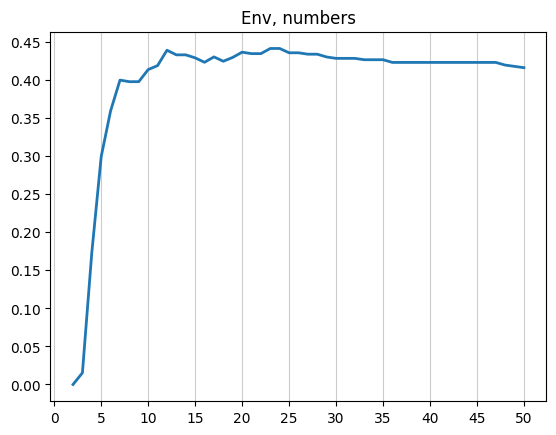

In [8]:
# считаем результаты
parent_sci_dict, children_sci, G = loader(sci_env='sci', lemmas_numbers='lemmas') # тут выбирать датасет
edges = build_taxo(parent_sci_dict)

f_metrics = []
tresholds = [x for x in range(2, 51)]

for x in tresholds:
    pred_edges = taxo_cleaner(edges, children_sci, x)
    P = len(set(G.edges()) & set(pred_edges)) / (len(set(pred_edges)) + 1e-15)
    R = len(set(G.edges()) & set(pred_edges)) / len(set(G.edges()))
    F = (2 * P * R) / (P + R + 1e-15)
    f_metrics.append(F)

# напечатаем максимальную величину
m = np.array(f_metrics).max()
print('Maximum F: ' + str(m))

# визуализация
fig, ax = plt.subplots()
ax.plot(tresholds, f_metrics, linewidth=2.0)
ax.set(yticks=np.arange(0, 0.5, 0.05),
       xticks=np.arange(0, 51, 5))

plt.grid(axis='x', color='0.8')
plt.title("Env, numbers")
plt.show()